In [4]:
import numpy 
from sklearn.neural_network import MLPRegressor 
from glob import glob
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import pandas as pd

In [12]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "C:/Users/aaron/OneDrive/Desktop/temp/CSE151b_final_project/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n)]      
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)

In [13]:
output = [d[1].flatten() for d in train_dataset]
in_put = [d[0].flatten() for d in train_dataset]
in_put[0]


array([-1303.7625276 ,  1138.31246403, -1303.51742401,  1138.71707532,
       -1303.21204952,  1139.21904709, -1302.84823902,  1139.8161695 ,
       -1302.42992386,  1140.50078551, -1301.96188374,  1141.26262409,
       -1301.4558762 ,  1142.08314552, -1300.92593051,  1142.94096098,
       -1300.38289221,  1143.81733833, -1299.83693982,  1144.69344162,
       -1299.30307674,  1145.54357628, -1298.78314062,  1146.36695077,
       -1298.26319828,  1147.18870759, -1297.74300535,  1148.00623848,
       -1297.22360328,  1148.81431759, -1296.70573541,  1149.61491347,
       -1296.18825919,  1150.41213503, -1295.67093647,  1151.20469326,
       -1295.15287446,  1151.99354667, -1294.63506871,  1152.7780662 ,
       -1294.11991324,  1153.5568605 , -1293.60805538,  1154.33176132,
       -1293.09994617,  1155.10151568, -1292.59382454,  1155.86684617,
       -1292.09151143,  1156.62596014, -1291.5911971 ,  1157.3821201 ,
       -1291.08718506,  1158.14207537, -1290.57690412,  1158.90776374,
      

In [14]:
a = in_put[0]

In [15]:
x = [ a[i] for i in range(len(a)) if i %2 == 0 ]
y =  [ a[i] for i in range(len(a)) if i %1 == 0 ]

In [16]:
xv = np.array(x[1:])-np.array(x[0:-1])
xv

array([0.24510359, 0.3053745 , 0.3638105 , 0.41831515, 0.46804012,
       0.50600754, 0.52994569, 0.5430383 , 0.5459524 , 0.53386308,
       0.51993611, 0.51994234, 0.52019294, 0.51940206, 0.51786787,
       0.51747623, 0.51732272, 0.51806201, 0.51780575, 0.51515547,
       0.51185786, 0.50810921, 0.50612163, 0.50231311, 0.50031433,
       0.50401204, 0.51028094, 0.5137649 , 0.51149676, 0.51057825,
       0.51005417, 0.50803358, 0.50451549, 0.50315388, 0.50250839,
       0.50132283, 0.500174  , 0.49550925, 0.49129274, 0.49029141,
       0.49810186, 0.50490375, 0.50256517, 0.50192865, 0.49799231,
       0.50158258, 0.5077064 , 0.50788241, 0.50858251])

In [17]:
def velocity(l):
    x = [ l[i] for i in range(len(l)) if i %2 == 0 ]
    y = [ l[i] for i in range(len(l)) if i %2 == 1 ]
    xv = (np.array(x[1:])-np.array(x[0:-1]))*10
    yv = (np.array(y[1:])-np.array(y[0:-1]))*10
    l = list(l) + list(xv)
    l = l + list(yv)

    return l



In [18]:
def acceleration(l):
    xv = [ l[i] for i in range(len(l)-98,len(l)) if i %2 == 0 ]
    yv = [ l[i] for i in range(len(l)-98,len(l)) if i %2 == 1 ]
    xa = np.array(xv[1:])-np.array(xv[0:-1])
    ya = np.array(yv[1:])-np.array(yv[0:-1])
    l = list(l) + list(xa)
    l = l + list(ya)
    return l


In [19]:
# num_iteration determines how deep the relationship we are calculating
# ex: num_iteration = 1, we add speed
# ex: num_iteration = 2, we add speed + acceleration
# ex: num_iteration = 3, we add speed + acceleration + accel-acceleration
def relation(l, num_iteration):
    length = len(l)
    # each loop adds one set of further relationship data
    for loop in range(num_iteration):
        xv = [ l[i] for i in range(len(l) - (length - 2*(loop)), len(l)) if i % 2 == 0 ]
        yv = [ l[i] for i in range(len(l) - (length - 2*(loop)), len(l)) if i % 2 == 1 ]
        xa = (np.array(xv[1:]) - np.array(xv[0:-1]))*10
        ya = (np.array(yv[1:]) - np.array(yv[0:-1]))*10
        l = list(l) + list(xa)
        l = l + list(ya)
    return l



In [20]:
def city_onehot(city):
    cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
    match = [city] * 6
    result = (np.array(match) == np.array(cities))*1
    return result
    

# AUSTIN 

In [21]:
def get_csv(city):
    
    #get data ready for this city
    train_dataset = ArgoverseDataset(city, split = "train")
    output = [d[1].flatten() for d in train_dataset]
    in_put = [d[0].flatten() for d in train_dataset]
    in_put_new = [relation(l,3) for l in in_put]
    #in_put_new_v3 = in_put_new_v2.append(city_onehot(city))
 
    # standardize the train data 
    #x_scaler = preprocessing.StandardScaler().fit(in_put)
   # y_scaler = preprocessing.StandardScaler().fit(output)
   # X_scaled = x_scaler.transform(in_put)
    #y_scaled = y_scaler.transform(output)
    
    
    #train the model for this city
    model = MLPRegressor(activation="relu", solver="adam", early_stopping=True,validation_fraction = 0.3,
    learning_rate="adaptive", max_iter=500,alpha=0.0005,hidden_layer_sizes = (32,64,128,256))
    
    model.fit(in_put_new,output)
    print(city, len(model.loss_curve_),model.loss_curve_)
    #get the predictoin 
    test_input,y =get_city_trajectories(city, "test", normalized=False)
    x_test = [ d.flatten() for d in test_input]
    in_put_newtest = [ relation(l,3) for l in x_test]

    #in_put_newtest_v3 = in_put_newtest_v2.append(city_onehot(city))
    # xtest_scaler = preprocessing.StandardScaler().fit(x_test)
    # xtest_scaled = xtest_scaler.transform(x_test)
    
    y= model.predict(in_put_newtest)
    #real_y =y_scaler.inverse_transform(y)
    return y

In [22]:
austin = get_csv("austin")

austin 13 [82283.68126530167, 152.05867112151225, 101.41262829787911, 83.76714157782708, 73.75964990834488, 69.32602521235951, 147.55682600055735, 75.25009061847479, 52.863159778686054, 51.03783526038237, 51.287009620907426, 44.677242395283656, 50.654725557274645]


In [172]:
aus = [None] * 10
for i in range(10):
    print(i)
    print("")
    k = get_csv("austin")
    aus[i] = k
    print("")

0

austin 13 [76433.0201323162, 164.4670737800278, 103.879012356919, 89.44564170419315, 77.40647412081086, 71.79247310600776, 89.42328553407107, 75.49474572401833, 104.55943979508001, 66.0909982476745, 62.335463280265536, 53.08829745513689, 100.58847599027949]

1

austin 13 [80017.2673833342, 167.42131262709205, 100.48355516107102, 80.24247425046421, 69.62866963477568, 59.56620122947986, 59.52458468382484, 55.89501072440625, 87.00191500290283, 47.90634190086048, 43.55148294235492, 61.40733667385686, 64.33444338553983]

2

austin 13 [81365.15533219864, 146.88576321471453, 95.58503714936658, 87.7006516719784, 73.92349243529685, 78.16367752464949, 64.77603107090076, 84.77397652118785, 58.159305278248695, 55.734024646610244, 49.33553255768148, 72.25957892758947, 43.6319919574859]

3

austin 13 [81249.02057832312, 170.95107169885858, 107.52771578107048, 90.42592632294485, 84.91716730584459, 90.53519694810203, 74.88883999720834, 69.81689118201464, 99.74755818296748, 61.341604051033116, 55.51

In [26]:
sub = []
sub.append(austin)
sub

[array([[  -11.66969084,  -565.15187175,    -9.61275411, ...,
          -563.84568606,   -54.20754933,  -550.56936125],
        [ -331.55632621,     5.47662757,  -335.09404323, ...,
            -4.85591091,  -310.01630664,    -4.99179287],
        [   50.13821884,  -247.49827694,    51.39335218, ...,
          -247.71709161,    50.9214363 ,  -247.31595836],
        ...,
        [ -690.59520586,   488.59348265,  -684.5043606 , ...,
           509.09441666,  -680.92814119,   501.82448195],
        [ -125.76287193,  1572.03050147,  -118.31520335, ...,
          1558.83149801,  -127.79874937,  1571.01363876],
        [  338.9267583 , -1485.04661147,   349.05590568, ...,
         -1484.90469095,   366.74420669, -1489.17366867]])]

# pittsburgh

In [28]:
def get_csv_pit(city):
    
    #get data ready for this city
    train_dataset = ArgoverseDataset(city, split = "train")
    output = [d[1].flatten() for d in train_dataset]
    in_put = [d[0].flatten() for d in train_dataset]
    in_put_new = [relation(l,3) for l in in_put]
    #in_put_new_v3 = in_put_new_v2.append(city_onehot(city))
 
    # standardize the train data 
    #x_scaler = preprocessing.StandardScaler().fit(in_put)
   # y_scaler = preprocessing.StandardScaler().fit(output)
   # X_scaled = x_scaler.transform(in_put)
    #y_scaled = y_scaler.transform(output)
    
    
    #train the model for this city
    model = MLPRegressor(activation="relu", solver="adam", early_stopping=True,validation_fraction = 0.3,
    learning_rate="adaptive", max_iter=500,alpha=0.0005,hidden_layer_sizes = (32,64,64,128))
    
    model.fit(in_put_new,output)
    print(city, len(model.loss_curve_),model.loss_curve_)
    #get the predictoin 
    test_input,y =get_city_trajectories(city, "test", normalized=False)
    x_test = [ d.flatten() for d in test_input]
    in_put_newtest = [ relation(l,3) for l in x_test]

    #in_put_newtest_v3 = in_put_newtest_v2.append(city_onehot(city))
    # xtest_scaler = preprocessing.StandardScaler().fit(x_test)
    # xtest_scaled = xtest_scaler.transform(x_test)
    
    y= model.predict(in_put_newtest)
    #real_y =y_scaler.inverse_transform(y)
    return y

In [29]:
pittsburgh = get_csv_pit("pittsburgh")

pittsburgh 13 [364421.9815574302, 128.45517081025045, 70.81677143243645, 59.23698777999326, 54.8780002199397, 53.42882403355955, 56.916339477359635, 58.57744702198554, 54.457342750327115, 79.66864685003378, 53.55378449762094, 70.85108381185553, 61.40039572238945]


In [173]:
pit = [None] * 10
for i in range(10):
    print(i)
    print("")
    k = get_csv_pit("pittsburgh")
    pit[i] = k
    print("")

0

pittsburgh 13 [473476.12236199545, 189.40163715218617, 89.37939505700156, 68.00502807866462, 58.67014916841671, 54.72189269159234, 54.90248027081344, 60.21356045330768, 80.45764266270857, 56.27177605786266, 50.91398036064921, 89.71893970604981, 55.584224139680146]

1

pittsburgh 13 [521295.9009475103, 300.8974778375365, 82.16305792375171, 59.106001846837025, 54.00472198829671, 50.708346145598185, 49.76594380422531, 50.29801696973566, 54.479822337881124, 65.6694295590721, 49.03901947753135, 53.700018316361664, 69.89278728834702]

2

pittsburgh 13 [424606.82473207056, 144.4989090636426, 75.64195386559945, 60.840531492060634, 56.70383293863451, 54.200919758445, 61.46566589069995, 116.79634306341804, 50.339821436080435, 52.76345367244542, 67.55021688569514, 135.32932281992606, 46.17889297936633]

3

pittsburgh 13 [388052.6266689979, 128.63630129983886, 70.92319706899028, 72.64185187088135, 67.89914269042845, 109.23149693362589, 53.94171950691242, 155.7793955024496, 54.877468369061354, 4

In [34]:
sub

[array([[  -11.66969084,  -565.15187175,    -9.61275411, ...,
          -563.84568606,   -54.20754933,  -550.56936125],
        [ -331.55632621,     5.47662757,  -335.09404323, ...,
            -4.85591091,  -310.01630664,    -4.99179287],
        [   50.13821884,  -247.49827694,    51.39335218, ...,
          -247.71709161,    50.9214363 ,  -247.31595836],
        ...,
        [ -690.59520586,   488.59348265,  -684.5043606 , ...,
           509.09441666,  -680.92814119,   501.82448195],
        [ -125.76287193,  1572.03050147,  -118.31520335, ...,
          1558.83149801,  -127.79874937,  1571.01363876],
        [  338.9267583 , -1485.04661147,   349.05590568, ...,
         -1484.90469095,   366.74420669, -1489.17366867]])]

# dearborn

In [115]:
def get_csv_dearb():
    
    city = "dearborn"
    
    #get data ready for this city
    train_dataset = ArgoverseDataset(city, split = "train")
    output = [d[1].flatten() for d in train_dataset]
    in_put = [d[0].flatten() for d in train_dataset]
    in_put_new = [relation(l,2) for l in in_put]
    #in_put_new_v3 = in_put_new_v2.append(city_onehot(city))
 
    # standardize the train data 
    #x_scaler = preprocessing.StandardScaler().fit(in_put)
   # y_scaler = preprocessing.StandardScaler().fit(output)
   # X_scaled = x_scaler.transform(in_put)
    #y_scaled = y_scaler.transform(output)
    
    
    #train the model for this city
    model = MLPRegressor(activation="relu", solver="adam", early_stopping=True,validation_fraction = 0.3,
    learning_rate="adaptive", max_iter=500,alpha=0.0005,hidden_layer_sizes = (32,256,256))
    
    model.fit(in_put_new,output)
    print(city, len(model.loss_curve_),model.loss_curve_)
    #get the predictoin 
    test_input,y =get_city_trajectories(city, "test", normalized=False)
    x_test = [ d.flatten() for d in test_input]
    in_put_newtest = [ relation(l,2) for l in x_test]

    #in_put_newtest_v3 = in_put_newtest_v2.append(city_onehot(city))
    # xtest_scaler = preprocessing.StandardScaler().fit(x_test)
    # xtest_scaled = xtest_scaler.transform(x_test)
    
    y= model.predict(in_put_newtest)
    #real_y =y_scaler.inverse_transform(y)
    return y

In [117]:
dear1 = [None] * 10
for i in range(10):
    print(i)
    print("")
    k = get_csv_dearb()
    dear1[i] = k
    print("")

0

dearborn 14 [1748039.8967248914, 909.5508764594066, 265.2762017089458, 171.75141567350786, 143.49160090792597, 126.52576796549621, 150.7417950266592, 265.3934776096923, 358.47901111753947, 163.3624375502992, 541.1854107875046, 91.63137611909464, 438.57077538158876, 285.69478696413466]

1

dearborn 14 [1950265.974747933, 976.1695200532048, 323.4988895072133, 205.7626814163115, 154.51900807988648, 130.97391657959028, 120.67914720936886, 113.64516883521668, 113.18743431873382, 191.13598877183028, 201.07114595044024, 185.61536122541528, 199.78004444510344, 114.13684083363377]

2

dearborn 14 [1974530.6859449223, 1175.6145730167718, 400.3882617840169, 257.5210698649669, 193.8085099452132, 160.00891301638327, 141.91340984651995, 125.5922270168642, 122.06052308803174, 183.16185931582942, 248.1342337490596, 146.61064746059375, 145.02485465203483, 200.6744711991257]

3

dearborn 13 [2007291.5565353653, 860.0315690064755, 243.94833124781277, 176.4996128029804, 197.57504001389054, 183.28670591

In [80]:
dearborn = get_csv_dearb()

dearborn 17 [3185801.575187682, 3157.9340680221308, 742.2523217822494, 386.2791655517591, 412.39927762579845, 267.35461577386997, 325.42251865487816, 259.7792857950256, 428.17313919451453, 154.41722427872844, 342.0764030769321, 350.1971192217515, 182.48047346551164, 355.1902215901836, 303.41450410595814, 736.1612322875968, 100.37552704238249]


# miami

In [120]:
def get_csv_mia():
    
    city = "miami"
    
    #get data ready for this city
    train_dataset = ArgoverseDataset(city, split = "train")
    output = [d[1].flatten() for d in train_dataset]
    in_put = [d[0].flatten() for d in train_dataset]
    in_put_new = [relation(l,3) for l in in_put]
    #in_put_new_v3 = in_put_new_v2.append(city_onehot(city))
 
    # standardize the train data 
    #x_scaler = preprocessing.StandardScaler().fit(in_put)
   # y_scaler = preprocessing.StandardScaler().fit(output)
   # X_scaled = x_scaler.transform(in_put)
    #y_scaled = y_scaler.transform(output)
    
    
    #train the model for this city
    model = MLPRegressor(activation="relu", solver="adam", early_stopping=True,validation_fraction = 0.3,
    learning_rate="adaptive", max_iter=500,alpha=0.0005,hidden_layer_sizes = (32,64,64,128))
    
    model.fit(in_put_new,output)
    print(city, len(model.loss_curve_),model.loss_curve_)
    #get the predictoin 
    test_input,y =get_city_trajectories(city, "test", normalized=False)
    x_test = [ d.flatten() for d in test_input]
    in_put_newtest = [ relation(l,3) for l in x_test]

    #in_put_newtest_v3 = in_put_newtest_v2.append(city_onehot(city))
    # xtest_scaler = preprocessing.StandardScaler().fit(x_test)
    # xtest_scaled = xtest_scaler.transform(x_test)
    
    y= model.predict(in_put_newtest)
    #real_y =y_scaler.inverse_transform(y)
    return y

In [121]:
miami = get_csv_mia()

miami 13 [464977.4320234552, 420.8947888011066, 198.67654837690154, 170.2247219256502, 168.50358547885193, 150.63180389867114, 149.97509796070412, 179.81654352619483, 129.0559900825624, 414.01827095649804, 157.0082682653992, 264.6135333471896, 73.67173387707739]


In [122]:
mia1 = [None] * 10
for i in range(10):
    print(i)
    print("")
    k = get_csv_mia()
    mia1[i] = k
    print("")

0

miami 13 [533274.0658924426, 429.06751659718213, 227.070553370647, 162.52437387133557, 284.55818003900623, 109.66939695549407, 113.03842162691022, 290.8366300319978, 76.64356186023032, 168.13778537989305, 191.58291661140933, 143.55858917891004, 121.21704889795137]

1

miami 13 [566987.4745822347, 745.5897445190739, 332.15388131601526, 297.98137455149856, 181.08346129036926, 178.96843105066137, 522.9574358660121, 106.73488846497777, 120.40662770138069, 122.19435672123755, 307.5729684276864, 154.21811163301902, 212.1569260629539]

2

miami 14 [492867.77075025305, 536.2974945445206, 259.8161712966424, 173.81287067050692, 212.369240404262, 195.82945504175734, 202.63346427618615, 82.83314753593191, 322.17691797637457, 72.38587577160791, 87.55821142739565, 434.37207765621247, 81.43338052034558, 175.05194910587898]

3

miami 13 [464430.29781717993, 565.9709218282925, 248.37899250287543, 238.2743276617512, 136.2306979892269, 198.1568651921576, 153.27789643912573, 420.90977684247275, 157.091

# washington-dc

In [123]:
def get_csv_wash():
    
    city = "washington-dc"
    
    #get data ready for this city
    train_dataset = ArgoverseDataset(city, split = "train")
    output = [d[1].flatten() for d in train_dataset]
    in_put = [d[0].flatten() for d in train_dataset]
    in_put_new = [relation(l,3) for l in in_put]
    #in_put_new_v3 = in_put_new_v2.append(city_onehot(city))
 
    # standardize the train data 
    #x_scaler = preprocessing.StandardScaler().fit(in_put)
   # y_scaler = preprocessing.StandardScaler().fit(output)
   # X_scaled = x_scaler.transform(in_put)
    #y_scaled = y_scaler.transform(output)
    
    
    #train the model for this city
    model = MLPRegressor(activation="relu", solver="adam", early_stopping=True,validation_fraction = 0.3,
    learning_rate="adaptive", max_iter=500,alpha=0.0005,hidden_layer_sizes = (32,64,128,256))
    
    model.fit(in_put_new,output)
    print(city, len(model.loss_curve_),model.loss_curve_)
    #get the predictoin 
    test_input,y =get_city_trajectories(city, "test", normalized=False)
    x_test = [ d.flatten() for d in test_input]
    in_put_newtest = [ relation(l,3) for l in x_test]

    #in_put_newtest_v3 = in_put_newtest_v2.append(city_onehot(city))
    # xtest_scaler = preprocessing.StandardScaler().fit(x_test)
    # xtest_scaled = xtest_scaler.transform(x_test)
    
    y= model.predict(in_put_newtest)
    #real_y =y_scaler.inverse_transform(y)
    return y

In [125]:
washington_dc = get_csv_wash()

washington-dc 14 [702251.1397968612, 2959.577724435651, 201.24316183496728, 139.38043438970257, 163.74634139327523, 193.0605313532842, 93.44960978372184, 261.3269714257439, 67.29864762049937, 77.81541606983794, 175.1598217551351, 117.05860923115209, 388.29225064136915, 57.43707965645295]


In [126]:
wash1 = [None] * 10
for i in range(10):
    print(i)
    print("")
    k = get_csv_wash()
    wash1[i] = k
    print("")

0

washington-dc 14 [694579.8335940012, 1969.0886431874987, 235.90212106951472, 175.7319626634125, 171.67119238526104, 116.96488979048999, 181.14261979055274, 160.29052189472858, 151.83779445976467, 128.66928228258521, 180.83983521879668, 65.38790288558585, 106.43790020278315, 165.05092632480418]

1

washington-dc 14 [628876.4004534832, 5336.673779384577, 278.1955094994151, 150.58490040989494, 115.05987908922997, 108.11040769593794, 108.66372221807138, 106.93192462339084, 96.59936132934051, 236.42482334604645, 65.29831265703018, 69.79225590388744, 97.61420581280618, 201.07394620813022]

2

washington-dc 14 [623739.6781692619, 619.0862089875461, 154.37599533631635, 99.15148062537594, 83.00098718041164, 70.64093424486494, 94.66745882559333, 92.04471486113451, 54.559926560855814, 80.4119658528254, 93.2264920410568, 72.06152554024418, 99.52171287201091, 102.21501463679932]

3

washington-dc 15 [479760.2825200887, 898.5801703902013, 185.11802509617524, 145.3993340964689, 118.93658426659394,

# palo-alto

In [164]:
def get_csv_palo_128():
    
    city = "palo-alto"
    
    #get data ready for this city
    train_dataset = ArgoverseDataset(city, split = "train")
    output = [d[1].flatten() for d in train_dataset]
    in_put = [d[0].flatten() for d in train_dataset]
    in_put_new = [relation(l,3) for l in in_put]
    #in_put_new_v3 = in_put_new_v2.append(city_onehot(city))
 
    # standardize the train data 
    #x_scaler = preprocessing.StandardScaler().fit(in_put)
   # y_scaler = preprocessing.StandardScaler().fit(output)
   # X_scaled = x_scaler.transform(in_put)
    #y_scaled = y_scaler.transform(output)
    
    
    #train the model for this city
    model = MLPRegressor(activation="relu", solver="adam", early_stopping=True,validation_fraction = 0.3,
    learning_rate="adaptive", max_iter=500,alpha=0.0005,hidden_layer_sizes = (128,128,256))
    
    model.fit(in_put_new,output)
    print(city, len(model.loss_curve_),model.loss_curve_)
    #get the predictoin 
    test_input,y =get_city_trajectories(city, "test", normalized=False)
    x_test = [ d.flatten() for d in test_input]
    in_put_newtest = [ relation(l,3) for l in x_test]

    #in_put_newtest_v3 = in_put_newtest_v2.append(city_onehot(city))
    # xtest_scaler = preprocessing.StandardScaler().fit(x_test)
    # xtest_scaled = xtest_scaler.transform(x_test)
    
    y= model.predict(in_put_newtest)
    #real_y =y_scaler.inverse_transform(y)
    return y

In [165]:
def get_csv_palo_64():
    
    city = "palo-alto"
    
    #get data ready for this city
    train_dataset = ArgoverseDataset(city, split = "train")
    output = [d[1].flatten() for d in train_dataset]
    in_put = [d[0].flatten() for d in train_dataset]
    in_put_new = [relation(l,3) for l in in_put]
    #in_put_new_v3 = in_put_new_v2.append(city_onehot(city))
 
    # standardize the train data 
    #x_scaler = preprocessing.StandardScaler().fit(in_put)
   # y_scaler = preprocessing.StandardScaler().fit(output)
   # X_scaled = x_scaler.transform(in_put)
    #y_scaled = y_scaler.transform(output)
    
    
    #train the model for this city
    model = MLPRegressor(activation="relu", solver="adam", early_stopping=True,validation_fraction = 0.3,
    learning_rate="adaptive", max_iter=500,alpha=0.0005,hidden_layer_sizes = (64,128,256))
    
    model.fit(in_put_new,output)
    print(city, len(model.loss_curve_),model.loss_curve_)
    #get the predictoin 
    test_input,y =get_city_trajectories(city, "test", normalized=False)
    x_test = [ d.flatten() for d in test_input]
    in_put_newtest = [ relation(l,3) for l in x_test]

    #in_put_newtest_v3 = in_put_newtest_v2.append(city_onehot(city))
    # xtest_scaler = preprocessing.StandardScaler().fit(x_test)
    # xtest_scaled = xtest_scaler.transform(x_test)
    
    y= model.predict(in_put_newtest)
    #real_y =y_scaler.inverse_transform(y)
    return y

In [163]:
palo_alto = get_csv_palo()

palo-alto 15 [230532.3301624333, 2285.28780373499, 588.0866974037349, 363.06358528365735, 272.18209608673317, 221.20701442299995, 189.36772921983936, 168.17447120227374, 153.0966327938939, 140.4840238367599, 130.26555386905517, 123.2946774028062, 116.00864673524354, 110.93136642020575, 107.13687486727758]


In [156]:
palo_alto1 = get_csv_palo()

palo-alto 16 [267562.8926760563, 3128.6283479047156, 649.2603307884389, 391.93166048200334, 274.1023624440701, 218.15770922581004, 183.73051735669273, 161.48824795421663, 144.9516108217681, 132.40928628455856, 123.38738579893567, 116.62483849898726, 110.21698769816729, 105.44956962695922, 101.44490487598296, 97.74104718008763]


In [166]:
palo1 = [None] * 10
for i in range(10):
    print(i)
    print("")
    k = get_csv_palo_128()
    palo1[i] = k
    print("")

0

palo-alto 15 [239806.86333432328, 2518.453017783378, 609.3630368387976, 360.71877073698494, 262.09708395309536, 211.08813575698127, 177.13783187782388, 153.42812025890615, 132.66048257508308, 118.96781113727315, 109.53880720520479, 101.6982644818686, 95.79264062564711, 91.0448583347388, 86.52137972191895]

1

palo-alto 15 [243141.7166569765, 2503.224052831155, 573.0295713895753, 362.7183221118667, 275.4558460130004, 223.97960653281163, 191.0317403150063, 166.86657685487418, 150.69146481962028, 137.98713759830696, 126.51269467874938, 118.95682747412233, 109.73311532337576, 106.89830093552193, 100.99152272133436]

2

palo-alto 16 [250906.82373226498, 2406.7965153525806, 568.6080637001724, 360.97800547044244, 268.3332348887684, 215.14645806566537, 181.93539670241051, 160.13968090237677, 143.81478971057973, 132.40305763665413, 123.00585064681368, 114.96771422074463, 109.6985479317363, 103.42315651887796, 99.16279574614883, 96.23300652375671]

3

palo-alto 15 [242325.31891254426, 2392.25

In [167]:
palo2 = [None] * 10
for i in range(10):
    print(i)
    print("")
    k = get_csv_palo_64()
    palo2[i] = k
    print("")

0

palo-alto 16 [270703.8986636976, 3147.578888250828, 698.897369713037, 414.655044533222, 295.9414916723772, 230.83000844409514, 196.4556568665962, 172.33600240514514, 156.10553422710686, 142.57247178833435, 132.7940327818609, 124.90816031497694, 118.26598764446798, 112.65154799036887, 107.81540015327086, 103.54914130678613]

1

palo-alto 16 [279874.20811707765, 3214.225714705214, 643.9118530101263, 378.994201991303, 276.4443053423056, 221.01521719124565, 187.79777279333263, 164.9049163241058, 147.11344907149524, 135.16056872007815, 126.34670902727856, 120.07267341444387, 113.3993306847103, 107.6579553266225, 103.50751009079698, 98.85889816315435]

2

palo-alto 16 [241797.71970217276, 2891.548660176705, 649.4999922479773, 395.7510697106635, 293.6443566476381, 232.11984661169234, 194.8795658129274, 169.6539158259895, 150.85959223295524, 138.39285538657612, 128.63959011864983, 120.77967688434357, 113.51088517119078, 107.4354010554494, 102.32127001762483, 98.94315431087135]

3

palo-alto

# submission

In [193]:
sub = []

In [ ]:
# cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]

In [178]:
aus[2]

array([[  -21.89093077,  -565.16464368,   -22.26513801, ...,
         -557.89429752,   -52.17192582,  -555.64280283],
       [ -328.28263857,    11.14920473,  -329.93788087, ...,
           11.8347536 ,  -322.57001602,    12.04818093],
       [   49.06268114,  -247.67437318,    50.50305074, ...,
         -249.1360315 ,    50.67147666,  -248.17964379],
       ...,
       [ -682.78651969,   495.19063604,  -684.16316731, ...,
          486.58727111,  -678.55497993,   495.90643084],
       [ -136.80610377,  1575.20713109,  -132.51440604, ...,
         1558.45050714,  -125.607208  ,  1563.01142983],
       [  338.74390972, -1488.70020404,   345.38566004, ...,
        -1492.32450094,   367.22114632, -1496.5167082 ]])

In [194]:
for x in aus[2]:
    sub.append(x)

In [179]:
miami

array([[ 5920.17046687,  1463.67035687,  5920.80409467, ...,
         1465.65955187,  5915.61379593,  1466.89901972],
       [-7888.46939382, -2193.24040461, -7893.53432696, ...,
        -2192.74904349, -7888.02544672, -2196.38188595],
       [ 6282.3536921 ,    57.54142528,  6281.20527903, ...,
           59.69465008,  6277.11607186,    60.09337129],
       ...,
       [  630.88526484,  1661.14081788,   625.18268998, ...,
         1657.69844095,   626.39892841,  1656.20641152],
       [  411.00207438,  3977.46902368,   413.60300491, ...,
         3980.96465202,   405.02679261,  3981.59514638],
       [ 5770.07362037,  1970.16101641,  5771.39461946, ...,
         1970.10397849,  5767.35026563,  1971.93453804]])

In [196]:
for x in miami:
    sub.append(x)

In [181]:
pit[4]

array([[4056.23876096,  205.39357585, 4055.62992905, ...,  205.66171898,
        4062.86382052,  206.45585035],
       [1483.49047628,  212.08509551, 1483.43959382, ...,  211.38900067,
        1488.2196251 ,  213.42713876],
       [1597.67364178,  362.39140506, 1596.48321886, ...,  367.41066731,
        1589.37797033,  362.19551804],
       ...,
       [1765.77133464,  430.22954015, 1767.22744647, ...,  424.58763283,
        1764.24694082,  425.90911089],
       [4670.6951359 , -588.24060769, 4668.03050053, ..., -590.77633574,
        4675.55106652, -590.97640029],
       [1264.41213617,  139.98269999, 1265.05087414, ...,  138.57957358,
        1274.4885493 ,  143.51333936]])

In [197]:
for x in pit[4]:
    sub.append(x)

In [184]:
dear1[8]

array([[ 9310.85306176,  3278.9700132 ,  9301.63213196, ...,
         3272.31814718,  9297.81059653,  3278.42347209],
       [ 2358.29465894,  3289.56569471,  2373.80910336, ...,
         3277.79750547,  2357.58323876,  3282.25620809],
       [10349.18552503,  3297.82288579, 10339.59110581, ...,
         3296.85101653, 10340.11354542,  3298.50727861],
       ...,
       [  662.3441521 ,  2702.63316661,   652.53643762, ...,
         2696.42450475,   668.9019114 ,  2701.67750609],
       [10058.39794252,  3604.35647477, 10052.96102438, ...,
         3603.7211584 , 10061.99698012,  3610.29039965],
       [ 9927.61077966,  3968.05003984,  9919.27261752, ...,
         3968.43289492,  9929.83288481,  3972.51756098]])

In [198]:
for x in dear1[8]:
    sub.append(x)

In [187]:
washington_dc

array([[1468.25234289,  723.25520352, 1473.91530554, ...,  719.40030358,
        1455.49749614,  729.75916069],
       [5740.21563454, 3288.3596879 , 5761.95391598, ..., 3278.46117928,
        5749.60571527, 3286.37934551],
       [2346.60216455, 1957.59023141, 2351.82847433, ..., 1952.91208337,
        2350.98676435, 1955.96188706],
       ...,
       [4989.75995648, 3798.51458697, 4990.8824365 , ..., 3791.22759807,
        4993.55946136, 3793.79703373],
       [4742.93056504, 1479.64900361, 4743.59825553, ..., 1471.8218589 ,
        4736.91182259, 1480.16202065],
       [3600.938806  , 1133.64721981, 3603.00926141, ..., 1123.38602542,
        3590.94349081, 1130.47037618]])

In [199]:
for x in washington_dc:
    sub.append(x)

In [189]:
palo1[0]

array([[ 5.92422280e+02,  1.88866215e+03,  5.81237420e+02, ...,
         1.89381585e+03,  5.86852315e+02,  1.86674280e+03],
       [ 1.42826735e+03,  1.70063607e+03,  1.43057368e+03, ...,
         1.70144124e+03,  1.43355565e+03,  1.69935563e+03],
       [-1.00058065e+03,  2.05860730e+03, -1.01982469e+03, ...,
         2.08112642e+03, -1.02258825e+03,  2.07528973e+03],
       ...,
       [-1.43149043e+03,  2.15882325e+03, -1.42883202e+03, ...,
         2.14610656e+03, -1.42362915e+03,  2.14761872e+03],
       [ 1.07363876e+03,  1.40057928e+03,  1.09173458e+03, ...,
         1.41321065e+03,  1.10125965e+03,  1.42247563e+03],
       [-3.67161876e+01,  4.00839057e+02, -1.54907951e+01, ...,
         3.79317436e+02,  1.99271592e+00,  4.03652381e+02]])

In [200]:
for x in palo1[0]:
    sub.append(x)

In [201]:
len(sub)

29843

In [210]:
# get all the prediction 
final =[]
for city in cities:
    x = get_csv(city)
    for ele in x:
        final.append(ele)


austin 13 [87014.48698907635, 140.28561743434912, 86.85656823962802, 77.4692534668652, 67.80028635486156, 67.16654096677601, 66.25741649518446, 78.75684929550988, 64.73083103417136, 150.71824783183746, 92.76803868923452, 43.769419649883254, 40.771690564632486]
miami 13 [306190.4756895019, 305.4441193580582, 133.08093461753387, 104.21918849280061, 110.72690039525325, 521.807457496006, 71.53839722745955, 99.05571060150307, 190.18235942836998, 157.92123417772368, 75.46794886883582, 238.80744474112248, 295.3593492680587]
pittsburgh 12 [252009.09130926777, 80.46077995869277, 59.384289713562296, 53.036307053914065, 50.519469878037285, 50.680575004860664, 51.93546933333693, 67.01436741016117, 71.26244755977943, 66.94612953145393, 78.78112114572288, 74.25425000096358]
dearborn 15 [1847640.5454760902, 897.1089375416985, 346.8254014390141, 349.46054245679767, 367.8978291457269, 736.4474799742783, 193.84939051987948, 130.6414358189908, 501.5777293517199, 185.8940338962141, 256.2852639743785, 316.

In [212]:
# get all the prediction 
final =[]
for city in cities:
    x = get_csv(city)
    for ele in x:
        final.append(ele)


austin 13 [89158.664711699, 202.96183249636303, 122.90758135661464, 97.70363134310293, 84.34516997356268, 76.91019973800952, 79.57071591481912, 67.98988878805875, 81.7722563021918, 57.32660297367294, 64.11471234256233, 54.51942372790613, 127.60348784258699]
miami 13 [366913.21348294383, 247.3028421508879, 139.0888114009814, 111.21565711784434, 108.2104066503093, 242.11203938636243, 94.0554485144158, 227.0563593483328, 73.13423115563695, 161.40458201580608, 159.29703738145045, 977.2238889071963, 84.6589101559133]
pittsburgh 13 [289170.25348719326, 121.92462522813916, 70.32651558163076, 60.46241232627047, 54.24181008367245, 50.21549440695759, 57.548157094153, 74.82103489378872, 90.22989847600178, 50.73494472809446, 92.77439474994064, 69.91290714825203, 89.5938935879156]
dearborn 15 [2186007.6197972544, 1368.5634281359314, 547.4658813071509, 463.1712117143912, 811.4788846161614, 216.55706237016332, 226.5293371574098, 518.2000180187921, 1014.0882956672222, 238.5729368213166, 124.8594655003

In [213]:
len(final)

29843

In [202]:
np.savetxt("prediction.csv", 
           sub,
           delimiter =", ",
           fmt ='% s')

In [215]:
df = pd.read_csv('C:/Users/ly264/Desktop/CSE151b_final_project/sample_submission.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/ly264/Desktop/CSE151b_final_project/sample_submission.csv'

In [244]:
final

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29839,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29840,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29841,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<function matplotlib.pyplot.show(close=None, block=None)>

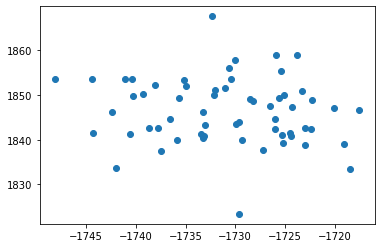

In [176]:
import matplotlib.pyplot as plt
y_show = y[677]
x_res = []
y_res = []
for i in range(0,120,2):
    x_res.append(y_show[i])
    y_res.append(y_show[i+1])
plt.scatter(x_res, y_res)
plt.show


In [249]:
    #get data ready for this city
    train_dataset = ArgoverseDataset("austin", split = "train")
    output = [d[1].flatten() for d in train_dataset]
    in_put = [d[0].flatten() for d in train_dataset]
    
    #train the model for this city
    model = MLPRegressor(activation="relu", solver="adam", early_stopping=False,
    learning_rate="adaptive", max_iter=400,alpha=0.001,hidden_layer_sizes = (32,64,64,128))
    
    model.fit(in_put,output)
    

    

MLPRegressor(alpha=0.001, hidden_layer_sizes=(32, 64, 64, 128),
             learning_rate='adaptive', max_iter=400)

In [33]:
import matplotlib.pyplot as plt

In [36]:
li = np.log((model.loss_curve_))

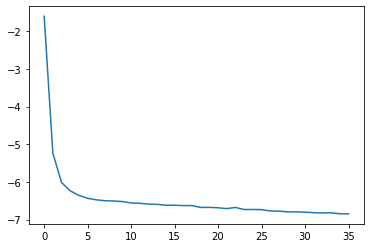

In [37]:
plt.plot(li)